In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../lite_data/dec15_extracted_domains.csv", header=0)
data.head()

,Unnamed: 0,author,domain,count
0,0,NaN,1950.today,1
1,1,NaN,4lakhdenahoga.com,2
2,2,NaN,aajtak.in,32
3,3,NaN,abc.net.au,1
4,4,NaN,abplive.com,20


In [3]:
data2 = pd.read_csv("../lite_data/aap_dec15_extracted_domains.csv", header=0)
data2.head()

,Unnamed: 0,author,domain,count
0,0,NaN,1.si,1
1,1,NaN,54.xn--h2brj9c,1
2,2,NaN,5dariyanews.com,1
3,3,NaN,aajtak.in,8
4,4,NaN,aamaadmiparty.org,1


In [4]:
data = pd.concat([data, data2])

In [5]:
data = data.dropna(subset=['author'])

## keep news only

In [6]:
news_domains = pd.read_csv("../lite_data/domaintitles_annotated.csv", header=0)
news_domains.head()
newslist = news_domains.loc[news_domains['is_news']==1]['domain'].tolist()

In [7]:
data = data.loc[data['domain'].isin(newslist)]

In [8]:
#map author and party handle
import glob
from collections import Counter, defaultdict

datafiles = glob.glob("/home/phadke/ONR/ONR/big_data/Twitter/*.csv")
author2party = defaultdict()

for d in datafiles:
    splitfilename = d.replace(".csv", "").split("_")
    party = splitfilename[len(splitfilename)-1]
    author = splitfilename[len(splitfilename)-2]
    author2party[author] = party


In [9]:
data['party'] = data['author'].apply(lambda x: author2party[x])

In [10]:
print(Counter(data[['author','party']].drop_duplicates()['party'].tolist()))

Counter({'BJP': 1964, 'INC': 1933, 'AAP': 315, 'DMK': 1})


## domain labels

In [11]:
domlabs = pd.read_csv("../lite_data/Website_List.csv", header=0)
domlabs.head()

,UniqueID,Website_Name,Political_Leaning,Website_URL,Language,MobileSite,PrintMedia,TVMedia,OnlineMedia,FacebookReach,TwitterReach,InstagramReach,AlexaGlobalRank,AlexaIndiaRank,Parent_Company,Website_Registrar,Registered_On,Expires_On,TrafficContributingSubDomains
0,1.0,Aaj Tak,RIGHT_TO_RIGHTCENTRE,aajtak.intoday.in,Hindi,m.aajtak.in,N,Y,Y,26.2M,9.8M,3.7M,607.7K,98.2K,Living Media Group (TV Today Network Limited),MPS Infotecnics Limited,16/02/2005,16/02/2029,"{'m.aajtak.in': '93.83%', 'OTHER': '6.17%'}"
1,2.0,Dainik Jagran,RIGHT_TO_RIGHTCENTRE,jagran.com,Hindi,m.jagran.com,Y,N,Y,14.8M,1.1M,58.5K,1.7K,132,Jagran Prakashan Limited,"Network Solutions, LLC",17/01/1997,18/01/2030,"{'jagran.com': '70.51%', 'epaper.jagran.com': ..."
2,3.0,RVCJ News,NaN,rvcj.com,English,N,N,N,Y,14.5M,193.0K,2.5M,26.9K,3.8K,RVCJ Digital Media Private Limited,"NameCheap, Inc.",20/04/2007,20/04/2022,"{'rvcj.com': '99.04%', 'OTHER': '0.97%'}"
3,4.0,Dainik Bhaskar,RIGHT_TO_RIGHTCENTRE,bhaskar.com,Hindi,N,Y,N,Y,14.3M,1.0M,988.2K,1.3K,107,D B Corp Limited,PDR Ltd. d/b/a PublicDomainRegistry.com,17/04/1998,16/04/2029,"{'bhaskar.com': '72.22%', 'epaper.bhaskar.com'..."
4,5.0,Zee News,RIGHT_TO_RIGHTCENTRE,zeenews.india.com,English,N,N,Y,Y,11.4M,3.2M,1.8M,74.9K,7.6K,Essel Group,"GoDaddy.com, LLC",13/08/1997,30/05/2027,"{'cdn.zeenews.com': '53.01%', 'my.zeenews.com'..."


In [12]:
print(Counter(domlabs['Political_Leaning'].tolist()))

Counter({'LEFT_TO_LEFTCENTRE': 39, 'RIGHT_TO_RIGHTCENTRE': 37, 'CENTRIST_AND_LEASTBIASED': 27, nan: 23})


In [13]:
import ast
for idx, row in domlabs.iterrows():
    print(type(ast.literal_eval(row['TrafficContributingSubDomains'])))
    break

<class 'dict'>


In [14]:
domlabs = domlabs.dropna(subset=['Political_Leaning'])
dom2label = defaultdict()

for idx, row in domlabs.iterrows():
    leaning = row['Political_Leaning']
    main_url = row['Website_URL']
    dom2label[main_url] = leaning
    traffic = ast.literal_eval(row['TrafficContributingSubDomains'])
    if traffic:
        for k in traffic.keys():
            if k!= 'OTHER':
                dom2label[k] = leaning

## keep news only

In [15]:
link_list = data.groupby("author")['domain'].apply(list).reset_index()
link_list.head()

,author,domain
0,01Bidar,"[indiatoday.in, livehindustan.com, prajavani.n..."
1,02,"[abplive.com, indiatoday.in, time8.in]"
2,0403,"[abplive.com, amarujala.com, hindustantimes.co..."
3,07Sharma4u,[abplive.com]
4,0914,"[abplive.com, abpnadu.com, business-standard.c..."


In [16]:
link_list['authorsize'] = link_list['domain'].apply(lambda x: len(set(x)))
print(len(link_list))
print(len(link_list.loc[link_list['authorsize']>1]))

4213
3465


In [17]:
multiple_shared_domains = link_list.loc[link_list['authorsize']>2]
multiple_shared_domains.head()

,author,domain,authorsize
0,01Bidar,"[indiatoday.in, livehindustan.com, prajavani.n...",4
1,02,"[abplive.com, indiatoday.in, time8.in]",3
2,0403,"[abplive.com, amarujala.com, hindustantimes.co...",7
4,0914,"[abplive.com, abpnadu.com, business-standard.c...",36
5,1,"[bhaskar.com, bhaskarhindi.com, hindustantimes...",5


In [18]:
nodes = defaultdict()
edges = defaultdict()

for idx, row in multiple_shared_domains.iterrows():
    authorlist = list(set(row['domain']))
    for a in authorlist:
        if a not in nodes:
            nodes[a] = 1
        else:
            nodes[a]+=1
            
    for i in range(len(authorlist)-1):
        for j in range(i+1, len(authorlist)):
            edgetuple = sorted([authorlist[i], authorlist[j]])
            if (edgetuple[0], edgetuple[1]) not in edges:
                edges[(edgetuple[0], edgetuple[1])] = 1
            else:
                edges[(edgetuple[0], edgetuple[1])] +=1


In [19]:
import networkx as nx

G = nx.Graph()

# for n in nodes.keys():
#     G.add_node(n, size=nodes[n], party=author2party[n])
    
ndlist = []
    
for e in edges:
    if edges[e] > 10:
        if e[0] not in ndlist:
            G.add_node(e[0], size=nodes[e[0]])
            ndlist.append(e[0])
        if e[1] not in ndlist:
            G.add_node(e[1], size=nodes[e[1]])
            ndlist.append(e[1])

        G.add_edge(e[0], e[1], weight=edges[e])

In [20]:
nodes_ = list(G.nodes)

In [21]:
admat = nx.adjacency_matrix(G, nodelist=nodes_, weight='weight')

In [22]:
print(type(admat))

<class 'scipy.sparse.csr.csr_matrix'>


In [23]:
admat.shape

(293, 293)

In [24]:
admat_dense = admat.toarray()

In [25]:
admat_dense.shape

(293, 293)

In [26]:
from sklearn.preprocessing import StandardScaler, normalize
#sc = normalize(admat_dense)
#sc.fit(admat_dense)
#admat_dense = sc.transform(admat_dense)
admat_dense = normalize(admat_dense)

## do PCA

In [27]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [28]:
pca = PCA(n_components=20)

In [29]:
X = pca.fit_transform(admat_dense)

In [30]:
exp_var_pca = pca.explained_variance_ratio_

In [31]:
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

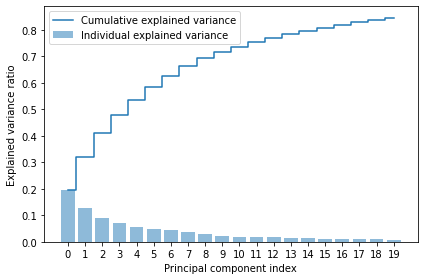

In [32]:
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
plt.legend(loc='best')
plt.tight_layout()
plt.show()


## cutting PCA at 5 dimensions

In [33]:
X.shape

(293, 20)

In [34]:
domainvectors = X[:, 0:10]
domainvectors.shape

(293, 10)

In [35]:
domainnames = nodes_
len(domainnames)

293

### label propagation data preparation

In [36]:
dom2label

defaultdict(None,
            {'aajtak.intoday.in': 'RIGHT_TO_RIGHTCENTRE',
             'm.aajtak.in': 'RIGHT_TO_RIGHTCENTRE',
             'jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'epaper.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'english.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'classifieds.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'mapi.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'm.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'naiduniaepaper.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'epaperapi.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'images.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'events.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'webmail.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'originakam-epaper.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'bhaskar.com': 'RIGHT_TO_RIGHTCENTRE',
             'epaper.bhaskar.com': 'RIGHT_TO_RIGHTCENTRE',
             'money.bhaskar.com': 'RIGHT_TO_RIGHTC

In [37]:
print(set([v for k,v in dom2label.items()]))

{'CENTRIST_AND_LEASTBIASED', 'LEFT_TO_LEFTCENTRE', 'RIGHT_TO_RIGHTCENTRE'}


In [38]:
label2num = {'LEFT_TO_LEFTCENTRE':1, 'CENTRIST_AND_LEASTBIASED':0, 'RIGHT_TO_RIGHTCENTRE':2}

In [39]:
nodelabels = []
for n in nodes_:
    if n in dom2label.keys():
        nodelabels.append(label2num[dom2label[n]])
    else:
        nodelabels.append(-1)

In [40]:
print(Counter(nodelabels))

Counter({-1: 222, 1: 25, 2: 24, 0: 22})


## label propagation algorithm

In [41]:
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
label_prop_model = LabelSpreading(alpha=0.01)

In [42]:
label_prop_model.fit(domainvectors, nodelabels)


LabelSpreading(alpha=0.01)

In [43]:
estimated_labs = label_prop_model.predict(domainvectors)

In [44]:
estimated_labs

array([2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1,
       1, 2, 2, 2, 2, 2, 1, 0, 2, 1, 1, 0, 1, 2, 2, 2, 1, 0, 1, 1, 1, 0,
       2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 0, 2, 1, 2,
       1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 1, 1, 2, 2, 1,
       1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 0, 2, 2, 2, 1, 1, 1, 1, 2, 2,
       2, 0, 0, 0, 2, 2, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 2, 1,
       0, 0, 2, 0, 0, 2, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 0, 0, 2, 1, 2, 1, 2, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 2, 0, 2, 1, 2, 1, 0, 1, 1, 2,
       1, 1, 1, 1, 2, 2, 1, 2, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 2, 2, 1, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 0, 1,
       0, 1, 1, 0, 1, 2, 2, 2, 0, 1, 1, 0, 0, 0, 1, 2, 2, 2, 0, 1, 1, 1,
       2, 0, 1, 0, 0, 1, 2])

## anlayze estimations

In [45]:
estimates = pd.DataFrame(columns=['domain', 'before_pred', 'after_pred'])

In [46]:
estimates['domain'] = nodes_
estimates['before_pred'] = nodelabels
estimates['after_pred'] = estimated_labs

In [47]:
estimates.head()

,domain,before_pred,after_pred
0,indiatoday.in,0,2
1,thehindu.com,1,0
2,prajavani.net,-1,1
3,livehindustan.com,0,2
4,abplive.com,-1,2


In [48]:
num2label = {v:k for k, v in label2num.items()}
estimates['predicted_party'] = estimates['after_pred'].apply(lambda x:num2label[x])

In [49]:
estimates.sample(10)

,domain,before_pred,after_pred,predicted_party
112,gaonconnection.com,-1,0,CENTRIST_AND_LEASTBIASED
274,risingkashmir.com,1,1,LEFT_TO_LEFTCENTRE
80,theweek.in,-1,0,CENTRIST_AND_LEASTBIASED
54,tv9bharatvarsh.com,-1,1,LEFT_TO_LEFTCENTRE
95,tribuneindia.com,0,2,RIGHT_TO_RIGHTCENTRE
137,dailyhunt.in,-1,2,RIGHT_TO_RIGHTCENTRE
154,businessinsider.in,0,2,RIGHT_TO_RIGHTCENTRE
19,opindia.com,2,2,RIGHT_TO_RIGHTCENTRE
285,techcrunch.com,-1,1,LEFT_TO_LEFTCENTRE
136,sanjeevnitoday.com,-1,0,CENTRIST_AND_LEASTBIASED


In [50]:
estimates['before_pred_label'] = estimates['before_pred'].apply(lambda x: num2label[x] if x>=0 else "unknown")
    

In [51]:
before_pred_dict = estimates.set_index('domain').to_dict()['before_pred_label']
predicted_labels = estimates.set_index('domain').to_dict()['predicted_party']

In [52]:
import networkx as nx

viz_G = nx.Graph()

# for n in nodes.keys():
#     G.add_node(n, size=nodes[n], party=author2party[n])
    
ndlist = []
    
for e in edges:
    if edges[e] > 10:
        if e[0] not in ndlist:
            viz_G.add_node(e[0], size=nodes[e[0]], before_pred=before_pred_dict[e[0]], prediction=predicted_labels[e[0]])
            ndlist.append(e[0])
        if e[1] not in ndlist:
            viz_G.add_node(e[1], size=nodes[e[1]], before_pred=before_pred_dict[e[1]], prediction=predicted_labels[e[1]])
            ndlist.append(e[1])

        viz_G.add_edge(e[0], e[1], weight=edges[e])

In [53]:
nx.write_gexf(viz_G, "label_propagation.gexf", encoding='utf_8')

### viz PCA clusters

In [54]:
estimates['pca_0'] = X[:,0]
estimates['pca_1'] = X[:,1]
estimates['pca_2'] = X[:,2]
estimates['pca_3'] = X[:,3]
estimates['pca_4'] = X[:,4]


In [55]:
estimates.sample(5)

,domain,before_pred,after_pred,predicted_party,before_pred_label,pca_0,pca_1,pca_2,pca_3,pca_4
102,freepressjournal.in,0,2,RIGHT_TO_RIGHTCENTRE,CENTRIST_AND_LEASTBIASED,-0.374221,-0.119248,0.040478,-0.081750,0.048029
75,asianetnews.com,-1,2,RIGHT_TO_RIGHTCENTRE,unknown,-0.352890,-0.252962,-0.027084,-0.147565,0.132127
54,tv9bharatvarsh.com,-1,1,LEFT_TO_LEFTCENTRE,unknown,-0.191087,0.187662,0.049149,0.244594,-0.034366
169,orfonline.org,-1,1,LEFT_TO_LEFTCENTRE,unknown,0.197757,-0.139666,-0.395977,0.079266,-0.256866
150,millenniumpost.in,-1,2,RIGHT_TO_RIGHTCENTRE,unknown,-0.317509,-0.186988,0.024758,-0.151470,0.115740


In [56]:
#!pip install seaborn

In [57]:
import seaborn as sns

<AxesSubplot:xlabel='pca_0', ylabel='pca_1'>

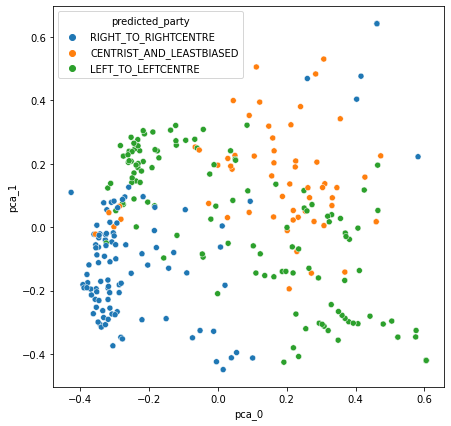

In [58]:
plt.figure(figsize=(7,7))
sns.scatterplot(data=estimates, x='pca_0', y='pca_1', hue='predicted_party')

In [59]:
estimates.loc[estimates['predicted_party']=='LEFT_TO_LEFTCENTRE'].sample(10)

,domain,before_pred,after_pred,predicted_party,before_pred_label,pca_0,pca_1,pca_2,pca_3,pca_4
99,bbc.in,-1,1,LEFT_TO_LEFTCENTRE,unknown,-0.241276,0.262808,0.130541,0.201354,-0.007593
84,scroll.in,1,1,LEFT_TO_LEFTCENTRE,LEFT_TO_LEFTCENTRE,-0.257529,0.209430,-0.064306,0.149816,-0.028779
206,aljazeera.com,-1,1,LEFT_TO_LEFTCENTRE,unknown,0.323577,0.016757,-0.256080,-0.069571,-0.102701
265,newsweek.com,-1,1,LEFT_TO_LEFTCENTRE,unknown,0.329379,-0.244483,-0.213597,0.005484,-0.291938
32,foreignpolicy.com,-1,1,LEFT_TO_LEFTCENTRE,unknown,0.464976,0.052605,-0.111409,0.076053,0.292305
197,japantimes.co.jp,-1,1,LEFT_TO_LEFTCENTRE,unknown,-0.121608,0.272554,-0.020736,0.259829,-0.085408
127,thegoan.net,-1,1,LEFT_TO_LEFTCENTRE,unknown,0.425285,0.117122,0.131169,-0.021974,0.040039
174,jantakareporter.com,-1,1,LEFT_TO_LEFTCENTRE,unknown,-0.213076,0.294272,0.105748,0.245686,-0.056586
223,mediavigil.com,-1,1,LEFT_TO_LEFTCENTRE,unknown,-0.137136,0.306101,0.100148,0.254715,-0.086361
49,altnews.in,1,1,LEFT_TO_LEFTCENTRE,LEFT_TO_LEFTCENTRE,-0.251840,0.283525,0.016768,0.220111,-0.014349
